In [ ]:
!pip install tensorflow==2.16.1
!pip install keras-tuner --upgrade

In [ ]:
import os
import warnings
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid")
matplotlib.rcParams['figure.figsize'] = [4, 3]
print(tf.__version__)

2.16.1


In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Helper functions

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.title('Photoperiod 08:16')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('train-val.png')
  plt.show()

In [ ]:
def create_dataset(data,time_window, label):
    X,Y=[],[]
    for i in range (len(data)-time_window-1) :
        a=data[i:i+time_window,0:data.shape[1]]
        X.append(a)
        Y.append(data[i+time_window,label])
    return (np.array(X),np.array(Y))

### Load data

In [ ]:
path='https://docs.google.com/spreadsheets/d/1zk4PeefBguNvwXV_QmJ7JjB9AWyfPOXIzLMiDvZFmk4/export?format=csv'
df = pd.read_csv(path)
df1=np.array(df['12_12'])
df

In [ ]:
df2 = df1.reshape(-1, 1)

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df2)

In [ ]:
train_split = round(0.8*len(df_scaled))
time_window = 3

In [ ]:
df1_train, df1_test= df_scaled[0:train_split],  df_scaled[train_split:]
x_train,y_train=create_dataset(df1_train[:,np.newaxis], time_window, 0)
x_test, y_test=create_dataset(df1_test[:,np.newaxis], time_window, 0)

In [ ]:
x_test.shape, y_test.shape

((2, 3, 1, 1), (2, 1))

In [ ]:
model=keras.Sequential()
model.add(keras.layers.LSTM(128, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(keras.layers.Dense(1,'linear'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
               loss='mean_squared_error',
               metrics=["mae"]
               )

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

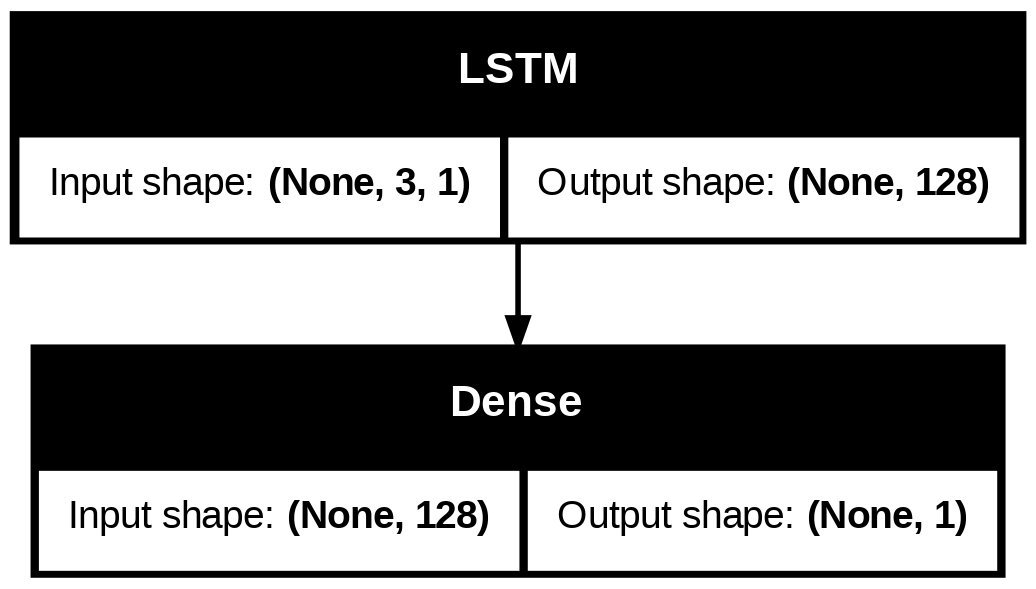

In [ ]:
keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1,
                    shuffle=False,
                    )

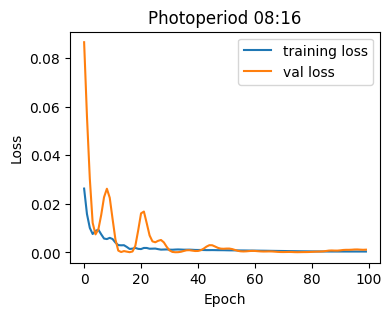

In [ ]:
plot_loss(history)

In [ ]:
df_hist = pd.DataFrame(history.history)
df_hist.describe()

,loss,mae,val_loss,val_mae
count,100.000000,100.000000,100.000000,100.000000
mean,0.001954,0.026335,0.004559,0.045523
std,0.003478,0.020309,0.011434,0.049048
min,0.000389,0.013071,0.000111,0.006950
25%,0.000532,0.014773,0.000408,0.018614
50%,0.000925,0.018801,0.000850,0.026299
75%,0.001422,0.026758,0.002542,0.049766
max,0.026304,0.119994,0.086523,0.293516


In [ ]:
score = model.evaluate(x_test, y_test)
score

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step - loss: 0.0877 - mae: 0.2884


[0.08769290149211884, 0.28837841749191284]

In [ ]:
pred = model.predict(x_test)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


array([[0.359733  ],
       [0.40306383]], dtype=float32)

In [ ]:
Y_pred = scaler.inverse_transform(pred)
Y_pred

array([[116.868256],
       [130.94536 ]], dtype=float32)

In [ ]:
Y = scaler.inverse_transform(y_test)
Y

array([[188.6875],
       [246.5   ]])

In [ ]:
df_compare = pd.DataFrame()
df_compare['Y'] = Y.squeeze()
df_compare['Y_pred'] = Y_pred.squeeze()
df_compare

,Y,Y_pred
0,188.6875,116.868256
1,246.5000,130.945358


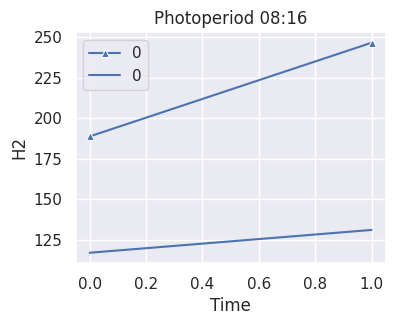

In [ ]:
sns.lineplot(Y, markers=["^", "o"])
sns.lineplot(Y_pred, )
plt.title('Photoperiod 08:16')
plt.xlabel('Time')
plt.ylabel('H2')
plt.legend()
plt.savefig('train-val.png')
plt.show()

In [ ]:
sns.relplot(data=df_compare)
plt.title('Photoperiod 08:16')
plt.xlabel('Time')
plt.ylabel('H2')
plt.legend()
plt.savefig('actual-pred.png')
plt.show()